In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import editdistance
import pickle
import time

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot

Using TensorFlow backend.
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\jsson\anaconda3\envs\ai_library\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\jsson\anaconda3\envs\ai

### Data

In [2]:
from data_icdar2015fst import GTUtility

gt_util_train = GTUtility('data/ICDAR2015_FST/')
gt_util_val = GTUtility('data/ICDAR2015_FST/', test=True)

file_name_train = 'gt_util_ICDAR2015_FST.pkl' 
file_name_val = 'gt_util_ICDAR2015_FST_val.pkl' 

pickle.dump(gt_util_train, open(file_name_train,'wb')) 
pickle.dump(gt_util_val, open(file_name_val,'wb'))

# with open(file_name_train, 'rb') as f1:
#     gt_util_synth1 = pickle.load(f1)
          
# with open(file_name_val, 'rb') as f2:
#     gt_util_synth2 = pickle.load(f2)           

# gt_util_icdar =  gt_util_synth1.merge(gt_util_synth2)
gt_util_icdar = gt_util_train.merge(gt_util_val)

print(gt_util_icdar)

Background              0
Text                 1944

images                462
objects              1944
per image            4.21
no annotation           0



In [3]:
# 다시 해야 할듯
# from data_ky_synth import GTUtility

# gt_util_synth = GTUtility('data/ky_synth')

file_name_synth = 'gt_util_ky_synth.pkl'

with open(file_name_synth, 'rb') as f:
    gt_util_synth = pickle.load(f)   
    print(gt_util_synth)

# pickle.dump(gt_util_synth, open(file_name_synth,'wb')) 

# with open(file_name_synth, 'rb') as f:
#     gt_util_synth = pickle.load(f)

Background              0
Text                44000

images              44000
objects             44000
per image            1.00
no annotation           0



In [4]:
from data_ky import GTUtility

# gt_util_ky = GTUtility('data/ky_dataset/',phase='train_extend')
# print(gt_util_ky)

file_name_ky = 'gt_util_ky_dataset.pkl' 

# pickle.dump(gt_util_ky, open(file_name_ky,'wb')) 

with open(file_name_ky, 'rb') as f:
    gt_util_ky = pickle.load(f)    
    print(gt_util_ky)

Background              0
Text                50488

images              24015
objects             50488
per image            2.10
no annotation           0



In [2]:
# from data_synthtext import GTUtility
# gt_util = GTUtility('data/SynthText/', polygon=True)

# file_name = 'gt_util_synthtext_seglink.pkl'
# pickle.dump(gt_util, open(file_name,'wb'))

# with open(file_name, 'rb') as f:
#     gt_util_synth = pickle.load(f)

# gt_util_train, gt_util_val = gt_util.split(0.8)
# #print(gt_util)

In [5]:
# gt_util_icdar = gt_util_train.merge(gt_util_val)
temp = gt_util_icdar.merge(gt_util_ky)
gt_util_final = gt_util_synth.merge(temp)
print(gt_util_final)

Background              0
Text                96432

images              68477
objects             96432
per image            1.41
no annotation           0



### Model

In [6]:
from crnn_utils import alphabet87 as alphabet

input_width = 256
#input_width = 1024
input_height = 32
batch_size = 128

input_shape = (input_width, input_height, 1)

model, model_pred = CRNN(input_shape, len(alphabet))

freeze = ['conv1_1', 'conv2_1', 'conv3_1', 'conv3_2', 
          'conv4_1', 'conv5_1'] #'conv6_1', #'lstm1', #'lstm2' 

experiment = 'crnn_lstm_ky'
# experiment = 'crnn_lstm_ky'

#model, model_pred = CRNN(input_shape, len(alphabet), gru=True)
#experiment = 'crnn_gru_synthtext'

#model, model_pred = CRNN(input_shape, len(alphabet), cnn=True)
#experiment = 'crnn_cnn_synthtext'
#experiment = 'crnn_cnn_synthtext_concat_continued'

max_string_len = model_pred.output_shape[1]

#꼭 체크하자!!
gen_train = InputGenerator(gt_util_final, batch_size, alphabet, input_shape[:2], 
                           grayscale=True, max_string_len=max_string_len, concatenate=True)


# gen_train = InputGenerator(gt_util_icdar, batch_size, alphabet, input_shape[:2], 
#                            grayscale=True, max_string_len=max_string_len, concatenate=True)


# gen_val = InputGenerator(gt_util_val, batch_size, alphabet, input_shape[:2], 
#                          grayscale=True, max_string_len=max_string_len, concatenate=False)
model.load_weights('./checkpoints/201806162129_crnn_lstm_synthtext/weights.400000.h5')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Training

In [7]:
checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#optimizer = Adam(lr=0.02, epsilon=0.001, clipnorm=1.)
for layer in model.layers: 
    layer.trainable = not layer.name in freeze


# dummy loss, loss is computed in lambda layer
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#model.summary()
#꼭 체크 generator랑 step epr epoch name체크하기
model.fit_generator(generator=gen_train.generate(), # batch_size here?
                    steps_per_epoch=gt_util_final.num_objects // batch_size,
                    epochs=40,
#                     validation_data=gen_val.generate(), # batch_size here?
#                     validation_steps=gt_util_val.num_objects // batch_size,
                    callbacks=[
                        ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', verbose=1, save_weights_only=True),
                        ModelSnapshot(checkdir, 10000),
                        Logger(checkdir)
                    ],
                    initial_epoch=0)


Epoch 1/40
NEW epoch
 70/753 [=>............................] - ETA: 5:40 - loss: 8.4923Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png


G:\ssd_detectors\crnn_data.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  word_ar = word_w / word_h


151/753 [=====>........................] - ETA: 4:56 - loss: 5.9020Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
499/753 [==================>...........] - ETA: 2:05 - loss: 3.5089Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
753/753 [==============================] - 321s 426ms/step - loss: 2.9883

Epoch 00001: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.001.h5
Epoch 2/40
104/753 [===>..........................] -

179/753 [======>.......................] - ETA: 2:38 - loss: 1.1553Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
265/753 [=========>....................] - ETA: 2:14 - loss: 1.1365Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
643/753 [========================>.....] - ETA: 30s - loss: 1.1250Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn

515/753 [===================>..........] - ETA: 1:05 - loss: 0.8766Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
585/753 [======================>.......] - ETA: 46s - loss: 0.8790Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
674/753 [=========================>....] - ETA: 21s - loss: 0.8761Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_

598/753 [======================>.......] - ETA: 42s - loss: 0.7357Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
635/753 [========================>.....] - ETA: 32s - loss: 0.7362Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
753/753 [==============================] - 207s 275ms/step - loss: 0.7401

Epoch 00013: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.013.h5
Epoch 14/40
211/753 [=======>......................] - 

748/753 [============================>.] - ETA: 1s - loss: 0.6398Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
753/753 [==============================] - 207s 275ms/step - loss: 0.6403

Epoch 00017: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.017.h5
Epoch 18/40
 14/753 [..............................] - ETA: 3:22 - loss: 0.6864Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
128/753 [====>.........................] - 

753/753 [==============================] - 210s 278ms/step - loss: 0.5744

Epoch 00021: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.021.h5
Epoch 22/40
 28/753 [>.............................] - ETA: 3:19 - loss: 0.6455Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
143/753 [====>.........................] - ETA: 2:47 - loss: 0.5779Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
324/753 [===========>..................] 

753/753 [==============================] - 209s 277ms/step - loss: 0.5208

Epoch 00025: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.025.h5
Epoch 26/40
154/753 [=====>........................] - ETA: 2:45 - loss: 0.5201Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
200/753 [======>.......................] - ETA: 2:32 - loss: 0.5106Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
351/753 [============>.................] 

731/753 [============================>.] - ETA: 6s - loss: 0.4716Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
753/753 [==============================] - 207s 276ms/step - loss: 0.4717

Epoch 00029: saving model to ./checkpoints/202006231539_crnn_lstm_ky/weights.029.h5
Epoch 30/40
276/753 [=========>....................] - ETA: 2:11 - loss: 0.4695Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
378/753 [==============>...............] - 

344/753 [============>.................] - ETA: 1:52 - loss: 0.4347Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_B_000.png
368/753 [=============>................] - ETA: 1:46 - loss: 0.4318Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
498/753 [==================>...........] - ETA: 1:10 - loss: 0.4266Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crn

319/753 [===========>..................] - ETA: 1:59 - loss: 0.4029Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_M_000.png
480/753 [==================>...........] - ETA: 1:15 - loss: 0.3897Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn_data.py", line 42, in crop_words
    word_w = int(round(height * word_ar))
OverflowError: cannot convert float infinity to integer

data/ky_dataset/chardataset\A002_R133_T_000.png
690/753 [==========================>...] - ETA: 17s - loss: 0.3901Traceback (most recent call last):
  File "G:\ssd_detectors\crnn_data.py", line 120, in generate
    self.grayscale)
  File "G:\ssd_detectors\crnn

In [2]:
# 테스트 셋 데이터
from data_ky import GTUtility

gt_util = GTUtility('data/ky_test/', phase='test')
print(gt_util)

Background              0
Text                   23

images                 20
objects                23
per image            1.15
no annotation           0



In [5]:
import tensorflow as tf
from crnn_model import CRNN
from crnn_data import InputGenerator
from crnn_utils import decode
from utils.training import Logger, ModelSnapshot
from crnn_utils import alphabet87 as alphabet

sess = tf.Session()

input_width = 256
#input_width = 1024
input_height = 32
batch_size = 128

input_shape = (input_width, input_height, 1)

model, model_pred = CRNN(input_shape, len(alphabet))
sess.run(tf.initializers.global_variables())
max_string_len = model_pred.output_shape[1]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
gen_val = InputGenerator(gt_util, batch_size, alphabet, input_shape[:2], 
                        grayscale=True, max_string_len=max_string_len)
model.load_weights('./checkpoints/202006231539_crnn_lstm_ky/weights.020.h5')

### Predict

NEW epoch
NEW epoch
NEW epoch
NEW epoch
NEW epoch
NEW epoch


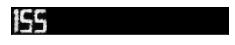

gt_str = 155                 , res_str =   155                


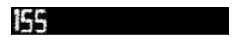

gt_str = 155                 , res_str =   155                


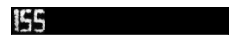

gt_str = 155                 , res_str =   155                


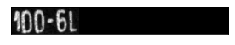

gt_str = 100-6L              , res_str =   1D0-6L             


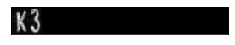

gt_str = K3                  , res_str =   K3                 


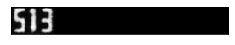

gt_str = 513                 , res_str =   513                


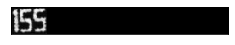

gt_str = 155                 , res_str =   155                


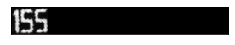

gt_str = 155                 , res_str =   155                


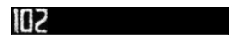

gt_str = 102                 , res_str =   102                


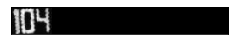

gt_str = 104                 , res_str =   104                


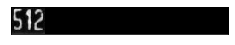

gt_str = 512                 , res_str =   512                


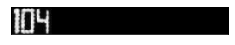

gt_str = 104                 , res_str =   104                


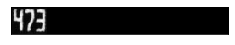

gt_str = 473                 , res_str =   473                


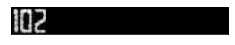

gt_str = 102                 , res_str =   102                


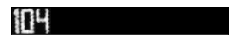

gt_str = 104                 , res_str =   104                


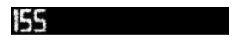

gt_str = 155                 , res_str =   155                


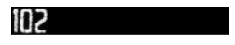

gt_str = 102                 , res_str =   102                


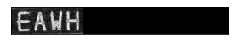

gt_str = EAWH                , res_str =   EAWH               


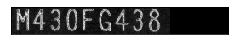

gt_str = M430FG438           , res_str =   M430FG438          


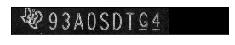

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


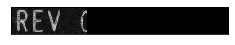

gt_str = REVC                , res_str =   REV                


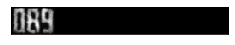

gt_str = 089                 , res_str =   089                


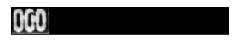

gt_str = 000                 , res_str =   000                


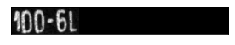

gt_str = 100-6L              , res_str =   1D0-6L             


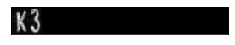

gt_str = K3                  , res_str =   K3                 


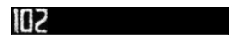

gt_str = 102                 , res_str =   102                


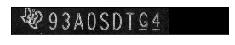

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


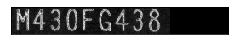

gt_str = M430FG438           , res_str =   M430FG438          


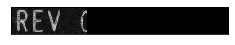

gt_str = REVC                , res_str =   REV                


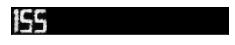

gt_str = 155                 , res_str =   155                


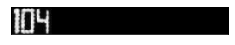

gt_str = 104                 , res_str =   104                


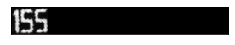

gt_str = 155                 , res_str =   155                


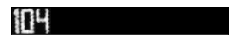

gt_str = 104                 , res_str =   104                


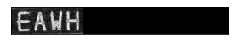

gt_str = EAWH                , res_str =   EAWH               


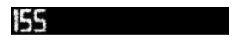

gt_str = 155                 , res_str =   155                


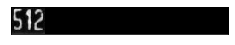

gt_str = 512                 , res_str =   512                


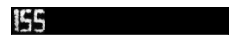

gt_str = 155                 , res_str =   155                


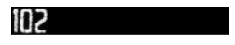

gt_str = 102                 , res_str =   102                


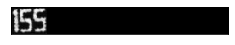

gt_str = 155                 , res_str =   155                


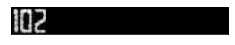

gt_str = 102                 , res_str =   102                


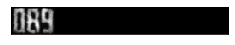

gt_str = 089                 , res_str =   089                


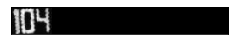

gt_str = 104                 , res_str =   104                


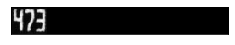

gt_str = 473                 , res_str =   473                


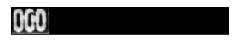

gt_str = 000                 , res_str =   000                


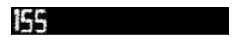

gt_str = 155                 , res_str =   155                


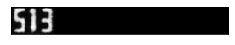

gt_str = 513                 , res_str =   513                


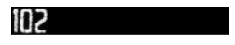

gt_str = 102                 , res_str =   102                


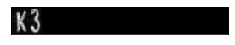

gt_str = K3                  , res_str =   K3                 


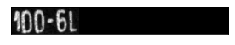

gt_str = 100-6L              , res_str =   1D0-6L             


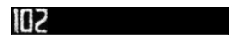

gt_str = 102                 , res_str =   102                


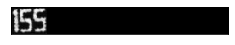

gt_str = 155                 , res_str =   155                


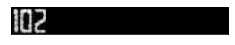

gt_str = 102                 , res_str =   102                


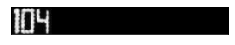

gt_str = 104                 , res_str =   104                


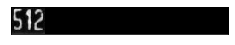

gt_str = 512                 , res_str =   512                


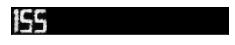

gt_str = 155                 , res_str =   155                


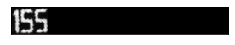

gt_str = 155                 , res_str =   155                


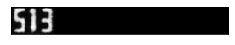

gt_str = 513                 , res_str =   513                


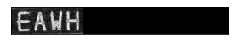

gt_str = EAWH                , res_str =   EAWH               


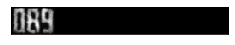

gt_str = 089                 , res_str =   089                


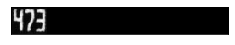

gt_str = 473                 , res_str =   473                


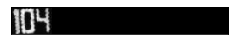

gt_str = 104                 , res_str =   104                


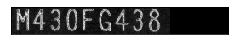

gt_str = M430FG438           , res_str =   M430FG438          


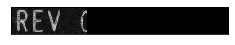

gt_str = REVC                , res_str =   REV                


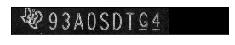

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


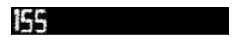

gt_str = 155                 , res_str =   155                


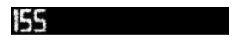

gt_str = 155                 , res_str =   155                


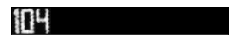

gt_str = 104                 , res_str =   104                


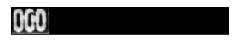

gt_str = 000                 , res_str =   000                


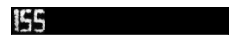

gt_str = 155                 , res_str =   155                


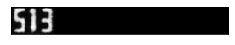

gt_str = 513                 , res_str =   513                


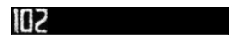

gt_str = 102                 , res_str =   102                


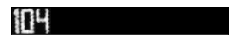

gt_str = 104                 , res_str =   104                


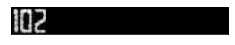

gt_str = 102                 , res_str =   102                


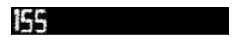

gt_str = 155                 , res_str =   155                


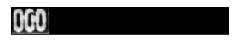

gt_str = 000                 , res_str =   000                


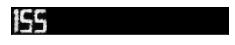

gt_str = 155                 , res_str =   155                


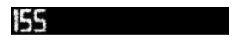

gt_str = 155                 , res_str =   155                


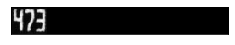

gt_str = 473                 , res_str =   473                


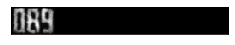

gt_str = 089                 , res_str =   089                


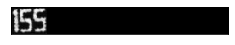

gt_str = 155                 , res_str =   155                


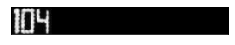

gt_str = 104                 , res_str =   104                


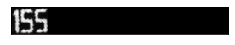

gt_str = 155                 , res_str =   155                


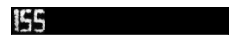

gt_str = 155                 , res_str =   155                


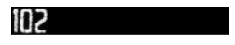

gt_str = 102                 , res_str =   102                


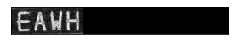

gt_str = EAWH                , res_str =   EAWH               


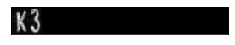

gt_str = K3                  , res_str =   K3                 


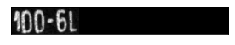

gt_str = 100-6L              , res_str =   1D0-6L             


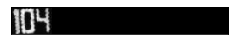

gt_str = 104                 , res_str =   104                


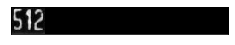

gt_str = 512                 , res_str =   512                


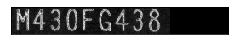

gt_str = M430FG438           , res_str =   M430FG438          


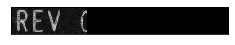

gt_str = REVC                , res_str =   REV                


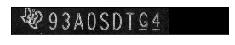

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


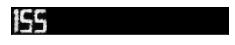

gt_str = 155                 , res_str =   155                


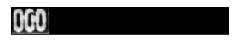

gt_str = 000                 , res_str =   000                


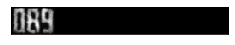

gt_str = 089                 , res_str =   089                


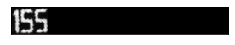

gt_str = 155                 , res_str =   155                


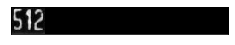

gt_str = 512                 , res_str =   512                


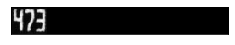

gt_str = 473                 , res_str =   473                


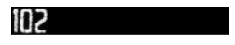

gt_str = 102                 , res_str =   102                


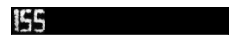

gt_str = 155                 , res_str =   155                


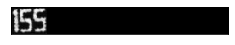

gt_str = 155                 , res_str =   155                


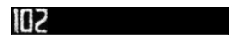

gt_str = 102                 , res_str =   102                


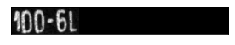

gt_str = 100-6L              , res_str =   1D0-6L             


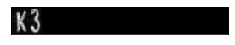

gt_str = K3                  , res_str =   K3                 


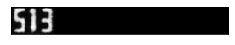

gt_str = 513                 , res_str =   513                


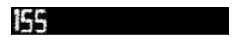

gt_str = 155                 , res_str =   155                


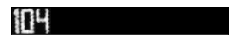

gt_str = 104                 , res_str =   104                


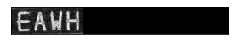

gt_str = EAWH                , res_str =   EAWH               


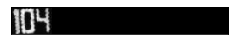

gt_str = 104                 , res_str =   104                


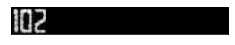

gt_str = 102                 , res_str =   102                


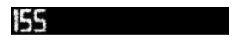

gt_str = 155                 , res_str =   155                


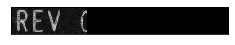

gt_str = REVC                , res_str =   REV                


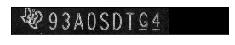

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


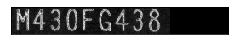

gt_str = M430FG438           , res_str =   M430FG438          


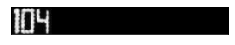

gt_str = 104                 , res_str =   104                


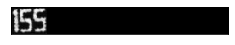

gt_str = 155                 , res_str =   155                


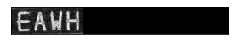

gt_str = EAWH                , res_str =   EAWH               


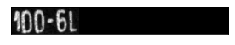

gt_str = 100-6L              , res_str =   1D0-6L             


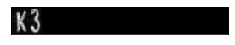

gt_str = K3                  , res_str =   K3                 


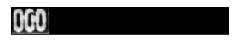

gt_str = 000                 , res_str =   000                


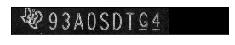

gt_str = 93A0SDTG4           , res_str =   lP93A0SDTG4        


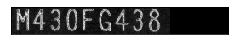

gt_str = M430FG438           , res_str =   M430FG438          


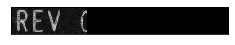

gt_str = REVC                , res_str =   REV                


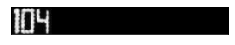

gt_str = 104                 , res_str =   104                


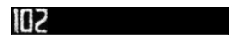

gt_str = 102                 , res_str =   102                


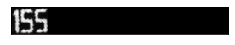

gt_str = 155                 , res_str =   155                


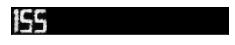

gt_str = 155                 , res_str =   155                


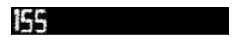

gt_str = 155                 , res_str =   155                

mean editdistance: 1.188
mean normalized editdistance: 0.335


In [9]:
# g = gen_train.generate()
g = gen_val.generate()
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

#for i in range(len(res)):
for i in range(len(res)):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    # display image
    plt.figure(figsize=[30,0.5])
    img = d[0]['image_input'][i]
    img = np.transpose(img, (1,0,2)) / 255
    if img.shape[-1] == 1:
        plt.imshow(img[:,:,0], cmap='gray')
    else:
        plt.imshow(img[:,:,(2,1,0)])
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
    print('gt_str = %-20s, res_str =  %-20s'  % (gt_str, res_str))
#     print('%-20s %-20s %s %0.2f' % (gt_str, res_str, ''.join(chars), ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

### Test

In [4]:
model.load_weights('./checkpoints/201806162129_crnn_lstm_synthtext/weights.400000.h5')
#model.load_weights('./checkpoints/201806190711_crnn_gru_synthtext/weights.400000.h5')
#model.load_weights('./checkpoints/202001111100_crnn_cnn_synthtext/weights.600000.h5')

In [5]:
g = gen_val.generate()
n = 100000
#n = batch_size

mean_ed = 0
mean_ed_norm = 0
mean_character_recogniton_rate = 0
sum_ed = 0
char_count = 0
correct_word_count = 0 

word_recognition_rate = 0

j = 0
while j < n:
    d = next(g)
    res = model_pred.predict(d[0]['image_input'])

    for i in range(len(res)):
        if not j < n: break
        j += 1
        
        # best path, real ocr applications use beam search with dictionary and language model
        chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
        gt_str = d[0]['source_str'][i]
        res_str = decode(chars)
        
        ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        ed_norm = ed / len(gt_str)
        mean_ed += ed
        mean_ed_norm += ed_norm
        
        sum_ed += ed
        char_count += len(gt_str)
        if ed == 0.: correct_word_count += 1
        
        #print('%20s %20s %f' %(gt_str, res_str, ed))


mean_ed /= j
mean_ed_norm /= j
character_recogniton_rate = (char_count-sum_ed) / char_count
word_recognition_rate = correct_word_count / j

print()
print('mean editdistance             %0.3f' % (mean_ed))
print('mean normalized editdistance  %0.3f' % (mean_ed_norm))
print('character recogniton rate     %0.3f' % (character_recogniton_rate))
print('word recognition rate         %0.3f' % (word_recognition_rate))

NEW epoch

mean editdistance             0.346
mean normalized editdistance  0.084
character recogniton rate     0.913
word recognition rate         0.853


In [7]:
%%timeit
res = model_pred.predict(d[0]['image_input'][1,None], batch_size=1)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

53.4 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit
res = model_pred.predict(d[0]['image_input'][:16], batch_size=16)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

57.7 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Example plots

NEW epoch


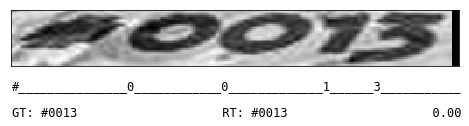

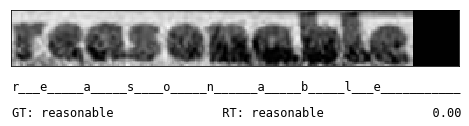

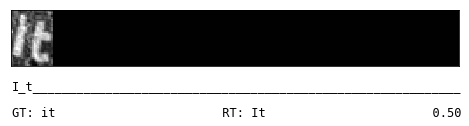

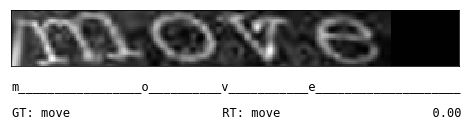

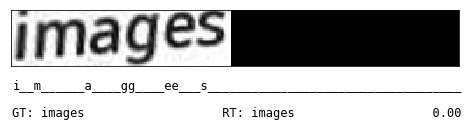

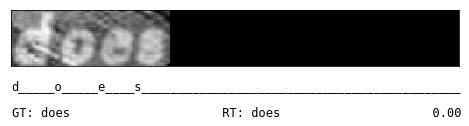

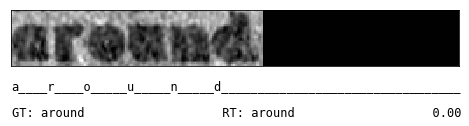

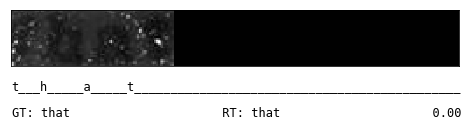

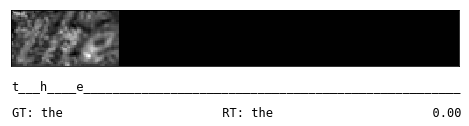

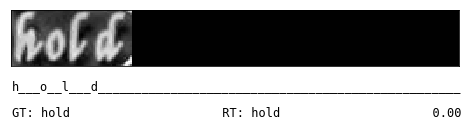


mean editdistance: 0.008
mean normalized editdistance: 0.004


In [10]:
g = gen_val.generate()
d = next(g)

res = model_pred.predict(d[0]['image_input'])

mean_ed = 0
mean_ed_norm = 0

font = {'family': 'monospace',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

plot_name = 'crnn_sythtext'

#for i in range(len(res)):
for i in range(10):
    # best path, real ocr applications use beam search with dictionary and language model
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    gt_str = d[0]['source_str'][i]
    res_str = decode(chars)
    
    ed = editdistance.eval(gt_str, res_str)
    #ed = levenshtein(gt_str, res_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    # display image
    img = d[0]['image_input'][i][:,:,0].T
    plt.figure(figsize=[10,1.03])
    plt.imshow(img, cmap='gray', interpolation=None)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.text(0, 45, '%s' % (''.join(chars)), fontdict=font)
    plt.text(0, 60, 'GT: %-24s RT: %-24s %0.2f' % (gt_str, res_str, ed_norm), fontdict=font)
    
    #file_name = 'plots/%s_recogniton_%03d.pgf' % (plot_name, i)
    file_name = 'plots/%s_recogniton_%03d.png' % (plot_name, i)
    #plt.savefig(file_name, bbox_inches='tight', dpi=300)
    #print(file_name)
    
    plt.show()
    
    #print('%-20s %-20s %s %0.2f' % (gt_str, res_str, ''.join(chars), ed_norm))

mean_ed /= len(res)
mean_ed_norm /= len(res)

print('\nmean editdistance: %0.3f\nmean normalized editdistance: %0.3f' % (mean_ed, mean_ed_norm))

In [3]:
from utils.model import calc_memory_usage, count_parameters

from crnn_utils import alphabet87 as alphabet
input_width = 256
input_height = 32

model_names = ['lstm', 'gru', 'cnn']
models = [
    CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True),
    CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True, gru=True),
    CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True, cnn=True),
]

for n, m in zip(model_names, models):
    print(n)
    calc_memory_usage(m)
    count_parameters(m)
    print()

lstm
model memory usage    41.17 MB
trainable            8,745,303
non-trainable            2,048

gru
model memory usage    38.17 MB
trainable            7,957,847
non-trainable            2,048

cnn
model memory usage    38.40 MB
trainable            7,872,087
non-trainable            5,632



In [9]:
%%timeit
res = models[0].predict(d[0]['image_input'][:1], batch_size=1)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

114 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
res = models[1].predict(d[0]['image_input'][:1], batch_size=1)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

85.1 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
res = models[2].predict(d[0]['image_input'][:1], batch_size=1)
for i in range(len(res)):
    chars = [alphabet[c] for c in np.argmax(res[i], axis=1)]
    res_str = decode(chars)

3.68 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
